In [11]:
import math
from scripts_stock.cfg.out_file_name import OutFileName
from scripts_stock.cfg.set_dir import ProjectDir
from scripts_stock.cfg.stock_list import *
from scripts_stock.utils.analysis.stock_stat_index import df_to_stock_df, stock_kdj
import os
from scripts_stock.utils.common import CommonScript
from scripts_stock.utils.string_process import StringProcess


def get_data_sql_str(table):
    return f"""SELECT *  FROM {table} limit 10 """

def get_data_sql_str_macd(stock_index):
    return f"""SELECT *  FROM t_stock_kdj_daily_all where date>='2022-9-23' and stock_index={stock_index} """

def get_train_data():
    aa = f"""
    select t1.*,t2.diff_5,t2.diff_3_cate,t2.diff_5,t2.diff_5_cate,t2.diff_7_cate
    from t_stock_kdj_daily_all AS t1
    join t_stock_return_fuquan AS t2
    on t1.date=t2.date and t1.stock_index=t2.stock_index
    where t2.date<='2024-09-01' and t2.date>='2023-01-01'
    """
    return aa

def get_predict_data():
    aa = f"""
    select t1.*,t2.diff_5,t2.diff_3_cate,t2.diff_5_cate,t2.diff_7_cate
    from t_stock_kdj_daily_all AS t1
    join t_stock_return_fuquan AS t2
    on t1.date=t2.date and t1.stock_index=t2.stock_index
    where close<8 and t2.date>='2024-09-01'
    """
    return aa

In [12]:
conn = CommonScript.connect_to_db("test.db")
cursor = conn.cursor()
df1 = pd.read_sql_query(get_train_data(),conn)
# df1 = df1[df1["stock_index"]==601398]

#df1.columns
features = [ 'macdh', 'cci', 'rsi_6', 'rsi_12', 'rsi_24', 'kdjk',
       'kdjd', 'kdjj', 'boll_ub', 'boll_lb', 'macd', 'macds', 'wr_6', 'wr_10']
df_pred_y = ['diff_3_cate']

df2 = df1[features+df_pred_y].dropna()
#print(df1.head(5))
df2.groupby(df_pred_y[0]).count()

,macdh,cci,rsi_6,rsi_12,rsi_24,kdjk,kdjd,kdjj,boll_ub,boll_lb,macd,macds,wr_6,wr_10
diff_3_cate,,,,,,,,,,,,,,
0.0,55603,55603,55603,55603,55603,55603,55603,55603,55603,55603,55603,55603,55603,55603
1.0,45789,45789,45789,45789,45789,45789,45789,45789,45789,45789,45789,45789,45789,45789


In [13]:
df1.groupby("stock_index").count()["open"].reset_index().sort_values("open")

,stock_index,open
74,2736,397
128,600584,399
0,1,404
160,600999,404
161,601006,404
...,...,...
90,600019,404
91,600025,404
92,600028,404
79,2916,404


In [14]:
# 定义一个函数来计算从当前行向前数有多少个值小于0，直到遇到第一个大于0的值
def count_negatives_until_positive(row,series):
    count = 0
    if row.name==0:
        return 0
    else:
        for value in series[row.name - 1::-1]:
            if value >= 0:
                break
            count += 1
    return count



In [15]:
df1["stock_index"].drop_duplicates()

0         600011
404          895
808       600010
1212      600660
1616      601728
           ...  
99377        877
99781     600061
100185       568
100589    600584
100988      2460
Name: stock_index, Length: 251, dtype: int64

In [224]:
# import numpy as np
# df3 = df1[df1["stock_index"]==601390]
# # 使用 rolling 窗口和 apply 方法计算每个位置的结果
# df4 = df3["macdh"].reset_index()[["macdh"]]
# #df4['Count_Negatives'] = df4.apply(lambda row: count_negatives_until_positive(row, df4['macdh']), axis=1)
# df3["macdh_forward_negative"] = df4.apply(lambda row: count_negatives_until_positive(row, df4['macdh']), axis=1).values
# #print(df3[["date","macdh","macdh_forward_negative"]].head(50))


# # new feature
# df3["kdjj_kdjk"] = df3["kdjj"]-df3["kdjk"]
# df3["kdjj_kdjk_pre1"] = df3['kdjj_kdjk'].shift(1)
# df3["kdjj_pre2"] = df3['kdjj'].shift(2)
# df3["kdjj_pre3"] = df3['kdjj'].shift(3)

# df3['kdjj_kdjk_cate'] = np.where(df3['kdjj_kdjk'] > 0, 1, 0)
# df3['kdjj_kdjk_pre1_cate'] = np.where(df3['kdjj_kdjk_pre1'] > 0, 1, 0)

/home/davidyu/software/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/davidyu/software/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/davidyu/software/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

In [37]:
import numpy as np
def add_features(df3):
    df4 = df3["macdh"].reset_index()[["macdh"]]
    #df4['Count_Negatives'] = df4.apply(lambda row: count_negatives_until_positive(row, df4['macdh']), axis=1)
    df3["macdh_forward_negative"] = df4.apply(lambda row: count_negatives_until_positive(row, df4['macdh']), axis=1).values
    #print(df3[["date","macdh","macdh_forward_negative"]].head(50))


    # new feature
    df3["kdjj_kdjk"] = df3["kdjj"]/df3["kdjk"]
    df3["boll_diff"]= df3["boll_ub"] - df3["boll_lb"]
    df3["kdjj_kdjk_pre1"] = df3['kdjj_kdjk'].shift(1)
    df3["kdjj_pre1"] = df3['kdjj'].shift(1)
    df3["kdjj_pre2"] = df3['kdjj'].shift(2)
    df3["kdjj_pre3"] = df3['kdjj'].shift(3)

    df3['kdjj_kdjk_cate'] = np.where(df3['kdjj_kdjk'] > 0, 1, 0)
    df3['kdjj_kdjk_pre1_cate'] = np.where(df3['kdjj_kdjk_pre1'] > 0, 1, 0)

    df3["rsi_12_6"] = df3["rsi_12"]/df3["rsi_6"]
    df3["rsi_24_6"] = df3["rsi_24"]/df3["rsi_6"]

    df3["macd_adj"] = df3["macd"]/df3["close"]
    return df3
df_list = []
for i in df1["stock_index"].drop_duplicates():
    df_out = df1[df1["stock_index"]==i]
    df_list.append(add_features(df_out))

df_out1 = pd.concat(df_list).dropna()

/home/davidyu/software/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/davidyu/software/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/davidyu/software/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [18]:
df_out1.head(5)

,date,open,close,high,low,stock_index,date_time,stock_date,macdh,cci,...,kdjj_kdjk,boll_diff,kdjj_kdjk_pre1,kdjj_pre1,kdjj_pre2,kdjj_pre3,kdjj_kdjk_cate,kdjj_kdjk_pre1_cate,rsi_12_6,rsi_24_6
3,2023-01-06,7.60,7.63,7.86,7.59,600011,2023-01-06,2023-01-06,0.124,102.515,...,1.130503,1.725,1.212508,104.089,106.665,115.844,1,1,0.880863,0.774039
4,2023-01-09,7.61,7.29,7.62,7.15,600011,2023-01-09,2023-01-09,0.092,42.393,...,0.904756,1.743,1.130503,96.147,104.089,106.665,1,1,1.085039,1.050999
5,2023-01-10,7.21,7.18,7.33,7.15,600011,2023-01-10,2023-01-10,0.060,16.013,...,0.681399,1.715,0.904756,67.132,96.147,104.089,1,1,1.153112,1.150818
6,2023-01-11,7.22,7.11,7.26,7.06,600011,2023-01-11,2023-01-11,0.031,-4.338,...,0.124732,1.684,0.681399,42.751,67.132,96.147,1,1,1.204691,1.226738
7,2023-01-12,7.11,7.04,7.14,7.00,600011,2023-01-12,2023-01-12,0.007,-33.410,...,-0.397288,1.638,0.124732,5.477,42.751,67.132,0,1,1.266601,1.317897


In [53]:
"""
rules 1
df5 = df_out1[(df_out1["kdjj_kdjk"]>1.15) & (df_out1["kdjj_kdjk_pre1"]<1)&(df_out1["kdjj"]<15)]
"""
# df5 = df_out1[(df_out1["kdjj_kdjk"]>0) & (df_out1["kdjj_kdjk_pre1"]<0)&(df_out1["kdjj_pre2"]<0)&(df_out1["kdjj"]<20)]
#&(abs(df_out1["macdh"])<0.07)
#&(df_out1["macd"]<0)
# &(df_out1["rsi_12_6"]<1)
df5 = df_out1[(df_out1["kdjj_kdjk"]>1.15) & (df_out1["kdjj_kdjk_pre1"]<1)&(df_out1["kdjj"]<15)]

#&(df_out1["kdjj_kdjk"]<1.1)&(df_out1["kdjj_kdjk"]>0)
df5 = df_out1[(df_out1["macd_adj"]<-0.06)]


#&(df_out1["kdjj_pre2"]<0)&(df_out1["kdjj"]<20)&(abs(df_out1["macdh"])<0.01)
# &(df_out1["kdjj_pre2"]<0)&(df_out1["kdjj_pre3"]<0)&(df_out1["kdjj"]<20)
#df5 = df3.dropna()
df6 = df5[["date","stock_index","macd_adj","kdjj","kdjj_kdjk","kdjj_kdjk_cate","kdjj_kdjk_pre1","kdjj_kdjk_pre1_cate",
     "macdh","macd","macdh_forward_negative","diff_5","diff_3_cate","diff_5_cate","diff_7_cate"]]
df6.head(10)

,date,stock_index,macd_adj,kdjj,kdjj_kdjk,kdjj_kdjk_cate,kdjj_kdjk_pre1,kdjj_kdjk_pre1_cate,macdh,macd,macdh_forward_negative,diff_5,diff_5,diff_3_cate,diff_5_cate,diff_7_cate
3934,2024-03-28,601699,-0.064193,0.634,0.105298,1,0.054596,1,-0.591,-1.185,12,0.040,0.040,1.0,1.0,1.0
3935,2024-03-29,601699,-0.063665,16.842,1.380718,1,0.105298,1,-0.498,-1.216,13,-0.013,-0.013,1.0,0.0,1.0
3936,2024-04-01,601699,-0.066066,20.312,1.415668,1,1.380718,1,-0.422,-1.246,14,0.050,0.050,1.0,1.0,1.0
3937,2024-04-02,601699,-0.065648,24.670,1.445395,1,1.415668,1,-0.338,-1.246,15,0.083,0.083,0.0,1.0,1.0
4004,2024-07-12,601699,-0.062399,5.221,0.681860,1,0.760567,1,-0.200,-0.999,27,-0.004,-0.004,0.0,0.0,0.0
4005,2024-07-15,601699,-0.062065,18.712,1.429379,1,0.681860,1,-0.173,-1.016,28,-0.027,-0.027,0.0,0.0,0.0
4006,2024-07-16,601699,-0.063541,23.977,1.484644,1,1.429379,1,-0.150,-1.030,29,-0.039,-0.039,0.0,0.0,0.0
4007,2024-07-17,601699,-0.066394,16.511,1.173573,1,1.484644,1,-0.140,-1.055,30,-0.028,-0.028,1.0,0.0,0.0
4008,2024-07-18,601699,-0.065215,19.697,1.247988,1,1.173573,1,-0.106,-1.048,31,-0.050,-0.050,0.0,0.0,0.0
4009,2024-07-19,601699,-0.065307,17.048,1.121063,1,1.247988,1,-0.079,-1.041,32,-0.029,-0.029,0.0,0.0,0.0


In [54]:
print(df6["diff_3_cate"].sum()/df6.shape[0])
print(df6["diff_5_cate"].sum()/df6.shape[0])
print(df6["diff_7_cate"].sum()/df6.shape[0])
print(df6["diff_5"].sum().values[0]/df6.shape[0])

print(df6.shape[0])
print(df1.shape)

0.5521091811414393
0.5905707196029777
0.5887096774193549
0.017905086848635246
1612
(101392, 28)


In [6]:
dff = pd.read_csv(os.path.join(ProjectDir.analysis_data_dir,"stock_kdj_daily_last.csv"))
dff["kdjj_kdjk"] = dff["kdjj"]/dff["kdjk"]
dff["kdjj_kdjk_pre1"] = dff['kdjj_kdjk'].shift(1)

dfff1 = dff[(dff["kdjj_kdjk"]>1.15) & (dff["kdjj_kdjk_pre1"]<1)&(dff["kdjj"]<30)]
dfff1[["date","close","stock_index","kdjj_kdjk","kdjj_kdjk_pre1","kdjj","macdh"]]

,date,close,stock_index,kdjj_kdjk,kdjj_kdjk_pre1,kdjj,macdh
46,2024-09-23,10.48,600025,1.382017,0.908532,29.987,-0.048
146,2024-09-23,4.49,600050,1.407916,0.249810,29.631,-0.015
196,2024-09-23,4.24,166,1.186986,0.015453,28.001,-0.012


In [55]:
dff = pd.read_csv(os.path.join(ProjectDir.analysis_data_dir,"stock_kdj_daily_last5.csv"))

dff["kdjj_kdjk"] = dff["kdjj"]/dff["kdjk"]
dff["kdjj_kdjk_pre1"] = dff['kdjj_kdjk'].shift(1)
dff["macd_adj"] = dff["macd"]/dff["close"]

dfff1 = dff[(dff["kdjj_kdjk"]>1.15) & (dff["kdjj_kdjk_pre1"]<1)&(dff["kdjj"]<15)]
dfff1[["date","close","stock_index","kdjj_kdjk","kdjj_kdjk_pre1","kdjj","macdh"]]

dfff1 = dff[(dff["macd_adj"]<-0.06)]
dfff1[["date","close","stock_index","kdjj_kdjk","kdjj_kdjk_pre1","kdjj","macdh"]]

,date,close,stock_index,kdjj_kdjk,kdjj_kdjk_pre1,kdjj,macdh
257,2024-09-19,3.96,3816,1.304255,1.067290,14.682,-0.065
258,2024-09-20,3.96,3816,1.358959,1.304255,17.748,-0.052
401,2024-09-18,13.57,1289,1.220374,0.714639,10.123,-0.111
500,2024-09-13,6.42,601872,1.259297,1.247388,16.119,-0.132
501,2024-09-18,6.58,601872,1.604446,1.259297,32.697,-0.097
502,2024-09-19,6.55,601872,1.612007,1.604446,42.370,-0.069
545,2024-09-13,142.19,596,-1.502337,1.567296,-11.251,-1.511
546,2024-09-18,140.60,596,-1.676240,-1.502337,-9.397,-1.759
547,2024-09-19,145.40,596,0.647309,-1.676240,6.710,-1.440
548,2024-09-20,144.51,596,1.059390,0.647309,13.521,-1.143


In [344]:
print(df6["diff_3_cate"].sum()/df6.shape[0])
print(df6["diff_5_cate"].sum()/df6.shape[0])
print(df6["diff_7_cate"].sum()/df6.shape[0])
print(df6["diff_5"].sum().values[0]/df6.shape[0])

print(df6.shape[0])
print(df1.shape)

0.5467625899280576
0.5683453237410072
0.5323741007194245
0.009064748201438853
139
(101392, 29)


In [281]:
df_out1.columns

Index(['date', 'open', 'close', 'high', 'low', 'stock_index', 'date_time',
       'stock_date', 'macdh', 'cci', 'rsi_6', 'rsi_12', 'rsi_24', 'kdjk',
       'kdjd', 'kdjj', 'boll_ub', 'boll_lb', 'macd', 'macds', 'wr_6', 'wr_10',
       'update_time', 'diff_5', 'diff_3_cate', 'diff_5', 'diff_5_cate',
       'diff_7_cate', 'boll_diff', 'macdh_forward_negative', 'kdjj_kdjk',
       'kdjj_kdjk_pre1', 'kdjj_pre1', 'kdjj_pre2', 'kdjj_pre3',
       'kdjj_kdjk_cate', 'kdjj_kdjk_pre1_cate'],
      dtype='object')

In [218]:
# df1[(df1["stock_index"]==600011)&(df1["date"]>="2023-02-28")][["date","close","stock_index","kdjj","kdjk"]]

,date,close,stock_index,kdjj,kdjk
35,2023-02-28,7.97,600011,70.822,50.877
36,2023-08-30,7.94,600011,-3.233,8.777
37,2023-08-31,7.95,600011,7.575,11.693
38,2023-09-01,7.81,600011,4.520,9.796
39,2023-09-04,7.60,600011,5.450,9.440
...,...,...,...,...,...
131,2024-08-26,7.00,600011,8.429,17.186
132,2024-08-27,6.96,600011,9.253,16.288
133,2024-08-28,7.04,600011,19.220,19.554
134,2024-08-29,6.94,600011,15.038,17.715


In [156]:
#df5 = df3[(df3["macdh_forward_negative"]>5) & (df3["macdh"]>0)]
df5 = df3[(df3["kdjj_kdjk"]>0) & (df3["kdjj_kdjk_pre1"]<0)&(df3["kdjj_pre2"]<0)&(df3["kdjj"]<30)]
#df5 = df3.dropna()
df5[["date","stock_index","kdjj","kdjj_kdjk","kdjj_kdjk_cate","kdjj_kdjk_pre1","kdjj_kdjk_pre1_cate",
     "macdh","macd","macdh_forward_negative","diff_3_cate","diff_5_cate","diff_7_cate"]]

,date,stock_index,kdjj,kdjj_kdjk,kdjj_kdjk_cate,kdjj_kdjk_pre1,kdjj_kdjk_pre1_cate,macdh,macd,macdh_forward_negative,diff_3_cate,diff_5_cate,diff_7_cate
24617,2023-05-25,601390,13.035,1.152,1,-5.93,0,-0.158,-0.168,11,1.0,1.0,1.0
24865,2024-06-04,601390,28.432,1.015,1,-16.06,0,-0.013,-0.048,4,1.0,0.0,0.0


In [289]:
from sklearn import tree#导入模块
from sklearn.model_selection import train_test_split
features = ["kdjj","kdjj_kdjk","kdjj_kdjk_cate","kdjj_kdjk_pre1","kdjj_kdjk_pre1_cate","kdjj_pre1","kdjj_pre2","kdjj_pre3","macdh"]
x_train = df_out1[features]


y_train = df_out1["diff_5_cate"]
clf=tree.DecisionTreeClassifier(max_depth=4)#实例化
clf=clf.fit(x_train,y_train)#用训练集数据训练模型

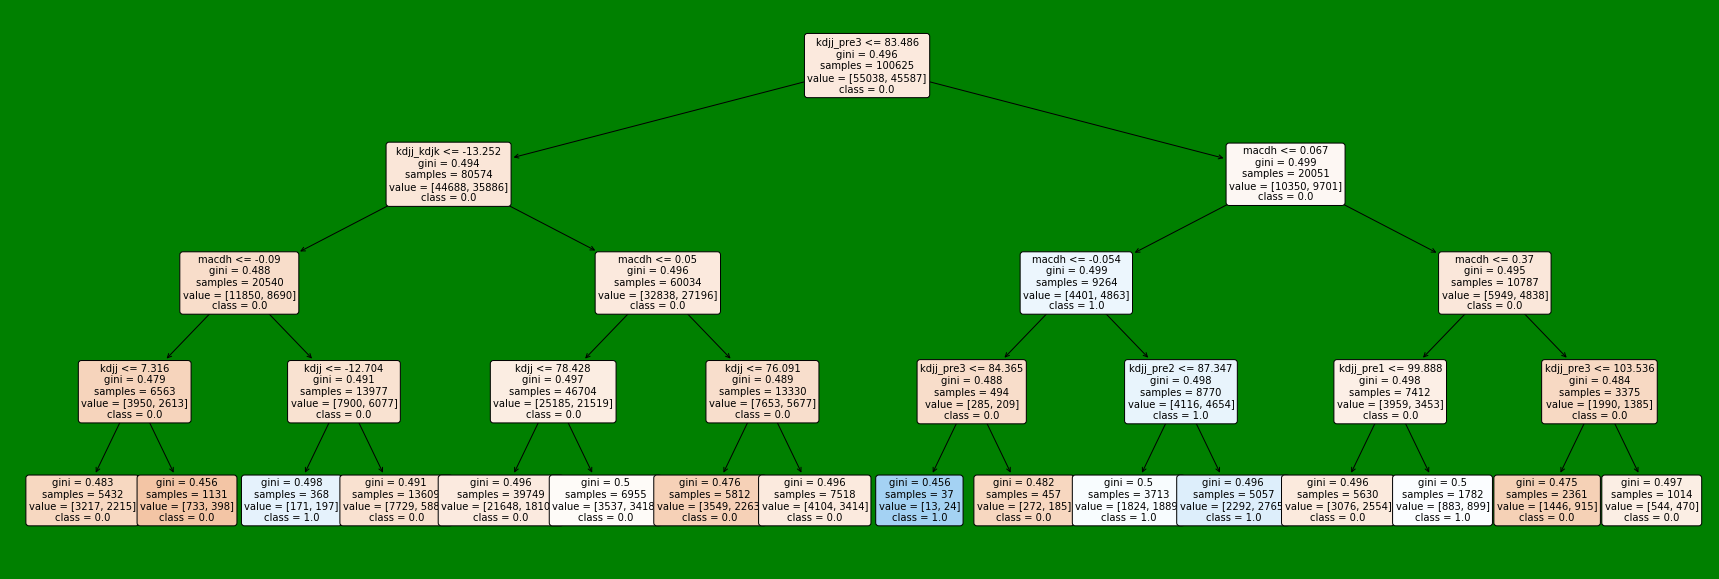

In [290]:
from sklearn.tree import plot_tree # 树图
import matplotlib.pyplot as plt

plt.figure(figsize=(30,10), facecolor= 'g')
feature_names = features
target_names = [str(x) for x in y_train.unique()]
plot_tree(clf, 
          feature_names = feature_names, 
          class_names = target_names, 
          filled = True, 
          rounded = True,
           fontsize=10)
plt.show()

In [116]:
df5[df5["macdh"]<=-0.026]

,date,open,close,high,low,stock_index,date_time,stock_date,macdh,cci,...,diff_5,diff_3_cate,diff_5_cate,diff_7_cate,boll_diff,macdh_forward_negative,kdjj_kdjk,kdjj_kdjk_pre1,kdjj_kdjk_cate,kdjj_kdjk_pre1_cate
2598,2023-05-24,4.34,4.15,4.35,4.14,601398,2023-05-24,2023-05-24,-0.036,-188.740,...,0.017,1.0,1.0,1.0,0.687,5,-21.150,-8.903,0,0
2599,2023-05-25,4.12,4.13,4.16,4.09,601398,2023-05-25,2023-05-25,-0.048,-199.361,...,0.029,1.0,1.0,1.0,0.683,6,-21.573,-21.150,0,0
2600,2023-05-26,4.13,4.19,4.23,4.11,601398,2023-05-26,2023-05-26,-0.049,-139.171,...,0.019,1.0,1.0,1.0,0.670,7,-13.809,-21.573,0,0
2601,2023-05-29,4.20,4.24,4.27,4.19,601398,2023-05-29,2023-05-29,-0.045,-85.366,...,0.026,1.0,1.0,1.0,0.650,8,-4.194,-13.809,0,0
2602,2023-05-30,4.23,4.21,4.27,4.18,601398,2023-05-30,2023-05-30,-0.043,-76.658,...,0.033,1.0,1.0,1.0,0.633,9,-2.233,-4.194,0,0
2603,2023-05-31,4.20,4.22,4.26,4.17,601398,2023-05-31,2023-05-31,-0.039,-66.208,...,0.043,1.0,1.0,1.0,0.604,10,0.616,-2.233,1,0
2604,2023-06-01,4.21,4.25,4.31,4.19,601398,2023-06-01,2023-06-01,-0.034,-39.538,...,0.054,1.0,1.0,1.0,0.611,11,4.776,0.616,1,1
2605,2023-06-02,4.25,4.27,4.29,4.23,601398,2023-06-02,2023-06-02,-0.027,-27.081,...,0.044,1.0,1.0,1.0,0.616,12,9.804,4.776,1,1
2793,2024-03-13,4.88,4.86,4.90,4.83,601398,2024-03-13,2024-03-13,-0.034,-207.080,...,0.006,1.0,1.0,1.0,0.354,10,-28.319,-22.803,0,0
2794,2024-03-14,4.85,4.88,4.92,4.83,601398,2024-03-14,2024-03-14,-0.038,-162.005,...,0.006,0.0,1.0,1.0,0.364,11,-25.084,-28.319,0,0


In [73]:

df3

/home/davidyu/software/Anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,open,close,high,low,stock_index,date_time,stock_date,macdh,cci,...,wr_10,update_time,diff_5,diff_3_cate,diff_5_cate,diff_7_cate,boll_diff,macdh_forward_negative,kdjj_kdjk,kdjj_kdjk_pre1
10951,2023-01-03,4.10,4.14,4.17,4.04,601658,2023-01-03,2023-01-03,0.003,120.076,...,10.714,2024-09-22 02:27:43.101738,0.022,1.0,1.0,1.0,0.291,0,31.049,NaN
10952,2023-01-04,4.17,4.24,4.26,4.12,601658,2023-01-04,2023-01-04,0.013,192.934,...,5.405,2024-09-22 02:27:43.101738,0.017,0.0,1.0,1.0,0.352,0,31.026,31.049
10953,2023-01-05,4.25,4.22,4.28,4.18,601658,2023-01-05,2023-01-05,0.016,165.591,...,15.385,2024-09-22 02:27:43.101738,0.028,1.0,1.0,1.0,0.380,0,23.134,31.026
10954,2023-01-06,4.22,4.21,4.24,4.17,601658,2023-01-06,2023-01-06,0.016,118.892,...,17.949,2024-09-22 02:27:43.101738,0.038,1.0,1.0,1.0,0.401,0,15.706,23.134
10955,2023-01-09,4.21,4.24,4.28,4.19,601658,2023-01-09,2023-01-09,0.017,114.174,...,10.526,2024-09-22 02:27:43.101738,0.014,1.0,1.0,1.0,0.430,0,13.908,15.706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11350,2024-08-26,5.12,5.14,5.16,5.08,601658,2024-08-26,2024-08-26,0.036,95.800,...,6.522,2024-09-22 02:27:43.101738,-0.078,0.0,0.0,0.0,0.622,0,11.534,15.453
11351,2024-08-27,5.14,5.18,5.22,5.13,601658,2024-08-27,2024-08-27,0.036,100.823,...,8.889,2024-09-22 02:27:43.101738,-0.106,0.0,0.0,0.0,0.674,0,7.803,11.534
11352,2024-08-28,5.17,5.11,5.20,5.08,601658,2024-08-28,2024-08-28,0.029,71.117,...,25.000,2024-09-22 02:27:43.101738,-0.096,0.0,0.0,0.0,0.694,0,-3.547,7.803
11353,2024-08-29,5.11,4.90,5.12,4.89,601658,2024-08-29,2024-08-29,0.009,-9.866,...,84.211,2024-09-22 02:27:43.101738,-0.057,0.0,0.0,0.0,0.687,0,-38.430,-3.547


In [40]:
import pandas as pd

# 创建示例 DataFrame
data = {
    'A': [1, -1, -2, 3, -1, -2, -3, 4, -1, -2]
}
df = pd.DataFrame(data)

# 定义一个函数来计算从当前行向前数有多少个值小于0，直到遇到第一个大于0的值（不包含当前行）
def count_negatives_until_positive(row, series):
    count = 0
    for value in series[row.name - 1::-1]:  # 从当前行的前一行开始向前遍历
        if value >= 0:
            break
        count += 1
    return count

# 使用 apply 方法计算每个位置的结果
df['Count_Negatives'] = df.apply(lambda row: count_negatives_until_positive(row, df['A']), axis=1)

print(df)

   A  Count_Negatives
0  1                2
1 -1                0
2 -2                1
3  3                2
4 -1                0
5 -2                1
6 -3                2
7  4                3
8 -1                0
9 -2                1
